In [113]:
import numpy as np
import warnings
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector

In [114]:
df = pd.read_csv('data/bank.csv', delimiter=";")

In [115]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [116]:
# Select the numerical variables to consider

var1 = 'age'
var2 = 'campaign'

Text(0.5, 1.0, 'age v. campaign')

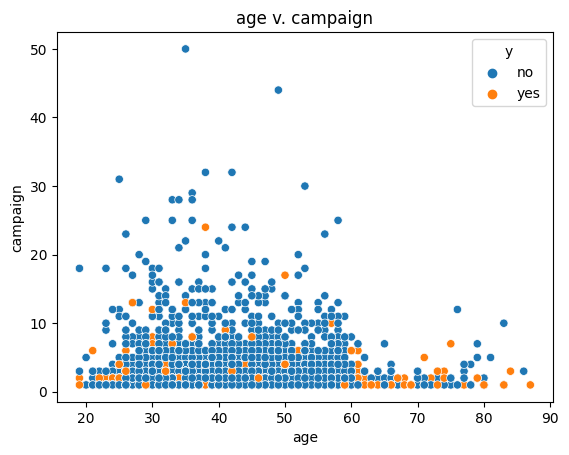

In [117]:
sns.scatterplot(data=df, x=var1, y=var2, hue='y')
plt.title(f"{var1} v. {var2}")

In [118]:
# Step 1:
# Filter the data
# We're only interested in 3 columns. (X: Campaign Duration, Y: Age, Success: Yes/No)

df = df[[var1, var2, 'y']]
df.head()

,age,campaign,y
0,30,1,no
1,33,1,no
2,35,1,no
3,30,4,no
4,59,1,no


In [119]:
# Step 2:
# Test/Train Split

X = df[[var1, var2]]
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(df.drop('y', axis = 1), df['y'], random_state=42)

In [120]:
# Step 3:
# KNN with GridSearchCV
# Performance and results

knn_params = {'knn__n_neighbors':range(3,15,4),
              'knn__weights':['uniform','distance'],
              'knn__p':[1,2]
             }

knn_pipe = Pipeline([('scale', StandardScaler()), ('knn', KNeighborsClassifier())])
knn_grid = GridSearchCV(knn_pipe, param_grid=knn_params)

knn = knn_grid.fit(X_train, y_train)

knn_train_score = accuracy_score(knn.predict(X_train), y_train)
knn_test_score = accuracy_score(knn.predict(X_test), y_test)
knn_best_params = knn.best_params_

print(knn_train_score)
print(knn_test_score)
print(knn_best_params)

0.884660766961652
0.8885941644562334
{'knn__n_neighbors': 11, 'knn__p': 2, 'knn__weights': 'uniform'}


Text(0.5, 1.0, 'KNN (age v. campaign) Sale Decision Boundary')

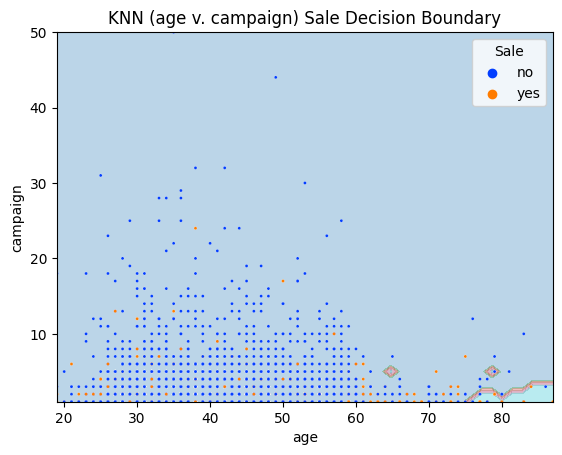

In [121]:
# Step 4:
# KNN Graphical representation

warnings.filterwarnings('ignore')
xx = np.linspace(X.iloc[:, 0].min(), X.iloc[:, 0].max(), 50)
yy = np.linspace(X.iloc[:, 1].min(), X.iloc[:, 1].max(), 50)
XX, YY = np.meshgrid(xx, yy)
grid = np.c_[XX.ravel(), YY.ravel()]
labels = pd.factorize(knn.predict(grid))[0]

plt.contourf(xx, yy, labels.reshape(XX.shape), cmap = 'tab10', alpha = 0.3)
sns.scatterplot(s=5, data = X, x = var1, y = var2, hue = y,  palette = 'bright')
plt.legend(title="Sale")
plt.title(f"KNN ({var1} v. {var2}) Sale Decision Boundary")

In [122]:
# Steps 5:
# Decision Tree wih GridSearchCV
# Performance and results

dtree_params = { 'max_depth': [2, 5, 10],
                 'min_samples_split': [0.1, 0.2, 0.05]
               }

dtree_grid = GridSearchCV(DecisionTreeClassifier(random_state = 42), param_grid=dtree_params).fit(X_train, y_train)

dtree = dtree_grid.fit(X_train,y_train)

dtree_train_score = accuracy_score(dtree.predict(X_train), y_train)
dtree_test_score = accuracy_score(dtree.predict(X_test), y_test)
dtree_best_params = dtree.best_params_

print(dtree_train_score)
print(dtree_test_score)
print(dtree_best_params)

0.8831858407079646
0.8894783377541998
{'max_depth': 2, 'min_samples_split': 0.1}


Text(0.5, 1.0, 'Decision Tree for age and campaign Sale Decision')

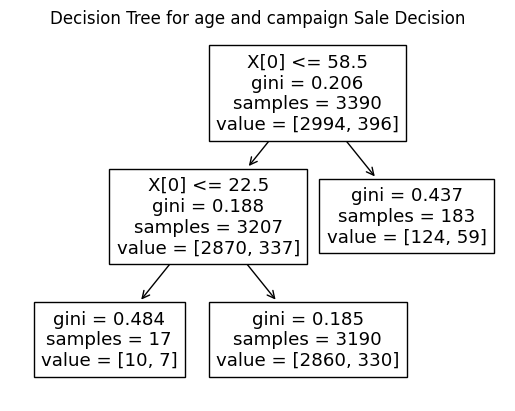

In [123]:
# Step 6:
# Decision Tree Graphical representation

tree_colored = plot_tree(dtree.best_estimator_.fit(X_train,y_train))
plt.title(f"Decision Tree for {var1} and {var2} Sale Decision")

In [124]:
# Steps 7:
# Logistic Regression with GridSearchCV
# Performance and results

extractor = SelectFromModel(LogisticRegression(penalty='l2', solver ='lbfgs', random_state = 42))
lgr_pipe = Pipeline([('scale', StandardScaler()), ('selector',extractor), ('lrg',LogisticRegression())])

lgr = lgr_pipe.fit(X_train, y_train)

lgr_train_score = accuracy_score(lgr.predict(X_train), y_train)
lgr_test_score = accuracy_score(lgr.predict(X_test), y_test)
lgr_best_params = {'penalty':'l2', 'solver':'lbfgs'}

print(lgr_train_score)
print(lgr_test_score)
print(lgr_best_params)

0.8831858407079646
0.8894783377541998
{'penalty': 'l2', 'solver': 'lbfgs'}


Text(0.5, 1.0, 'Logistic Regression (age v. campaign) Sale Decision Boundary')

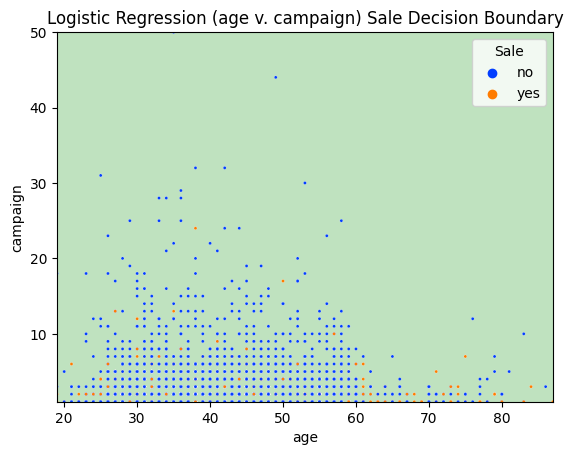

In [125]:
# Step 8:
# Logistic Regression Graphical representation

xx = np.linspace(X.iloc[:, 0].min(), X.iloc[:, 0].max(), 50)
yy = np.linspace(X.iloc[:, 1].min(), X.iloc[:, 1].max(), 50)
XX, YY = np.meshgrid(xx, yy)
grid = np.c_[XX.ravel(), YY.ravel()]
labels = pd.factorize(lgr.predict(grid))[0]

plt.contourf(xx, yy, labels.reshape(XX.shape), cmap = 'tab10', alpha = 0.3)
sns.scatterplot(s=5, data = X, x = var1, y = var2, hue = y,  palette = 'bright')
plt.legend(title="Sale")
plt.title(f"Logistic Regression ({var1} v. {var2}) Sale Decision Boundary")

In [126]:
# Steps 9:
# SVC with GridSearchCV
# Performance and results

svc_params = {'svc__kernel': ['rbf','linear','sigmoid'],
              'svc__gamma': [0.1, 1.0,10.0],
              'svc__coef0':[0,1,2]}

svc_pipe = Pipeline([('scale', StandardScaler()), ('svc', SVC())])
svc_grid = GridSearchCV(svc_pipe, param_grid=svc_params)

svc = svc_grid.fit(X_train, y_train)

svc_train_score = accuracy_score(svc.predict(X_train), y_train)
svc_test_score = accuracy_score(svc.predict(X_test), y_test)
svc_best_params = svc.best_params_

print(svc_train_score)
print(svc_test_score)
print(svc_best_params)

0.8831858407079646
0.8894783377541998
{'svc__coef0': 0, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}


Text(0.5, 1.0, 'SVC (age v. campaign) Sale Decision Boundary')

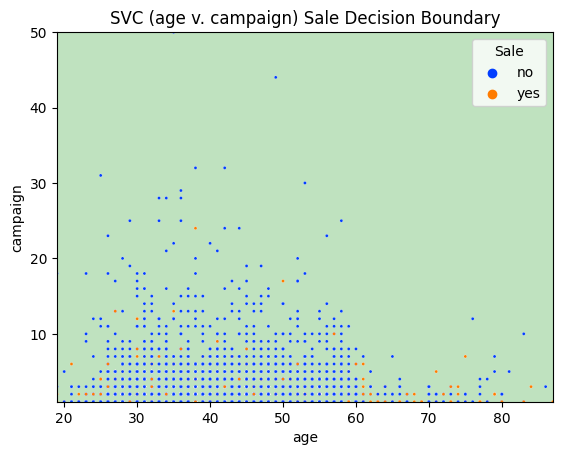

In [127]:
# Step 10:
# SVC Graphical representation

xx = np.linspace(X.iloc[:, 0].min(), X.iloc[:, 0].max(), 50)
yy = np.linspace(X.iloc[:, 1].min(), X.iloc[:, 1].max(), 50)
XX, YY = np.meshgrid(xx, yy)
grid = np.c_[XX.ravel(), YY.ravel()]
labels = pd.factorize(svc.predict(grid))[0]

plt.contourf(xx, yy, labels.reshape(XX.shape), cmap = 'tab10', alpha = 0.3)
sns.scatterplot(s=5, data = X, x = var1, y = var2, hue = y,  palette = 'bright')
plt.legend(title="Sale")
plt.title(f"SVC ({var1} v. {var2}) Sale Decision Boundary")

In [128]:
# Step 11:
# Performance Comparison

res_dict = {'model': ['KNN', 'Decision Tree', 'Logistic Regression', 'SVC'],
            'train score': [knn_train_score, dtree_train_score, lgr_train_score, svc_train_score],
            'test score': [knn_test_score, dtree_test_score, lgr_test_score, svc_test_score],
            'best params': [knn_best_params, dtree_best_params, lgr_best_params, svc_best_params],
           }

results_df = pd.DataFrame(res_dict).set_index('model')


pd.set_option("display.max_colwidth",100)
results_df.head()

,train score,test score,best params
model,,,
KNN,0.884661,0.888594,"{'knn__n_neighbors': 11, 'knn__p': 2, 'knn__weights': 'uniform'}"
Decision Tree,0.883186,0.889478,"{'max_depth': 2, 'min_samples_split': 0.1}"
Logistic Regression,0.883186,0.889478,"{'penalty': 'l2', 'solver': 'lbfgs'}"
SVC,0.883186,0.889478,"{'svc__coef0': 0, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}"
